# <center>Mortage Defaults<br>Dealing with Rare Event Predictions</center>

<center>Michael Siebel</center>
<center>March 2020</center>

<br>
    
## Table of Contents
- [Goals](#Goals)<br>
- [Load Packages](#Load-Packages)<br>
- [Set Up Functions](#Set-Up-Functions)<br>
- [Implement Data Cleanings](#Implement-Data-Cleanings)<br>
- [Analysis Functions](#Analysis-Functions)<br>
- [Imbalanced Prediction](#Imbalanced-Prediction)
- [Downsampling Prediction](#Downsampling-Prediction)<br>
- [Upsampling Prediction](#Upsampling-Prediction)<br>
- [Conclusion](#Conclusion)<br>

# Goals  
<br>

Using Fannie Mae mortgage data, I investigated which types of loans are at greatest risk of default (i.e., being foreclosed upon) at the beginning of the 2008 financial crisis.  This is made difficult as loan defaults, even at the height of the financial crisis, was a "rare event", meaning it occurs at such a low frequency that a model becomes far better at predicting what DOES NOT cause a default compared to what DOES cause a default.  
<br>

The goal of this project was to test how downsampling and upsampling techniques can improve predictions of rare events.  
<br>

Downsampling techniques create balanced data by removing majority class until it matches the frequency minority class.  Upsampling techniques create balanced data by resample duplicates of minority class until it matches the frequency of the majority class).  
<br>

I train the model three times, once with the original balance of default to non-defaults, second with downsampling the training sample, and third with upsampling the training sampling.  I show that downsampling and upsampling the training samples improves predictions.  

# Load Packages

In [1]:
# Core Packages
import pandas as pd
import numpy as np
import random
# Convert Time Features
from datetime import datetime as dt
# Data Visualizations
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='chesterish', grid=False)
# Splitting Data
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# Machine Learning Packages
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# Save Runtime
import time
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
# Output Statistics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

# Set Up Functions  
<br>

In this post, I set up all data wrangling and data analysis as a series of functions, which will enable me to reuse on data from subsequent years (future projects) and various analysis techniques (this project).

### Fannie Mae data comes in two forms:  
### 1) acquistion data and 2) performance data  
<br>
1) The acquisition data includes one observation for each loan with each feature representing knowledge Fannie Mae has when acquiring the loan (e.g., balance, primary lender, credit score, etc.).  

2) The performance data includes observations for each month each loan is held and information on the payment of the loan.  
<br>
I use the acquisition data as predictors for a dichotomous categorization of whether the homeowner defaulted on their loan, a target variable I create using the performance data and merging onto the acquisition data.  

In [2]:
# Load the data
def load_data(acq, per):
    df_acq = pd.read_csv(acq, sep='|', header=None)
    df_per = pd.read_csv(per, sep='|', header=None)
    
    # Specify the name of the columns
    df_acq.columns = ['LoanID','Channel','SellerName','OrInterestRate','OrUnpaidPrinc','OrLoanTerm',
            'OrDate','FirstPayment','OrLTV','OrCLTV','NumBorrow','DTIRat','CreditScore',
            'FTHomeBuyer','LoanPurpose','PropertyType','NumUnits','OccStatus','PropertyState',
            'Zip','MortInsPerc','ProductType','CoCreditScore','MortInsType','RelMortInd']
    
    df_per.columns = ['LoanID','MonthRep','Servicer','CurrInterestRate','CAUPB','LoanAge','MonthsToMaturity',
              'AdMonthsToMaturity','MaturityDate','MSA','CLDS','ModFlag','ZeroBalCode','ZeroBalDate',
              'LastInstallDate','ForeclosureDate','DispositionDate','FCCCost','PPRC','AssetRecCost','MHRC',
              'ATFHP','NetSaleProceeds','CreditEnhProceeds','RPMWP','OFP','NIBUPB','PFUPB','RMWPF',
              'FPWA','ServicingIndicator']
    
    return df_acq, df_per

Performance data is much larger as it is transaction based, while the acquistion data has the loan owner as its unit of analysis.  
<br>
I retain only the most recent performance transaction relating to foreclosure, then drop all other variables except  Loan ID (the primary key) and merge performance data onto acquisition data.  
<br>
I recode performance data into dichotomous categorization of whether loan was foreclosed upon.

In [3]:
# Merge foreclosures from performance data to acquistion data
def merge_df(df_acq, df_per):
    
    # Columns to maintain from Performance Data
    per_ColKeep = ['LoanID','ForeclosureDate']
    df_per = df_per[per_ColKeep]
    df_per.drop_duplicates(subset='LoanID', keep='last', inplace=True)
    df = pd.merge(df_acq, df_per, on='LoanID', how='inner')
    
    # Set Foreclosed to binary
    df.loc[df['ForeclosureDate'].isnull(), 'Foreclosed'] = 0
    df.loc[df['ForeclosureDate'].notnull(),'Foreclosed'] = 1
    df = df.drop(columns='ForeclosureDate')
    df['Foreclosed'] = df['Foreclosed'].astype(int)
    
    # Drop mergeID column
    df = df.drop(df.columns[[0]], axis=1)
    
    return df

I remove features with really high missingness or no data variation, and then impute on features with low missingness

In [4]:
def missing_treat(df):
    # Find features with 10% missing or more
    condition = ( df.isnull().sum(axis=0)/df.shape[0]*100 ) 
    df_HighMissing = condition > 10 
    
    # Save features that contain missing data
    df_HighMissing = df_HighMissing.index[df_HighMissing.values == True]
    
    # remove high missing features
    df = df.drop(labels=df_HighMissing, axis=1)
    
    # remove ProductType, it only had one value    
    df = df.drop(labels=['ProductType'], axis=1)
    
    # remove Zip and in favor of Property State
    df = df.drop(labels=['Zip'], axis=1)
    
    # impute on the mean for low missing features that are continuous   
    df_cont = df.select_dtypes(include=['float64', 'int64'])
    df[df_cont.columns] = df_cont.apply(lambda x: x.fillna(x.mean()),axis=0)
    
    # impute on the mode for low missing features that are categorical   
    df_cat = df.select_dtypes(include=['object'])
    df[df_cat.columns] = df_cat.apply(lambda x: x.fillna(x.mode()),axis=0)  
    
    return df

Changing date features to numeric

In [5]:
# Changing date features to ordinal variables using the function toordinal()
def change_date(df):
    
    # Origination Date
    df['OrDate'] = df['OrDate'].apply(lambda x: dt.strptime(x, '%m/%Y').toordinal())
    
    # Date of First Payment
    df['FirstPayment'] = df['FirstPayment'].apply(lambda x: dt.strptime(x, '%m/%Y').toordinal())
    
    return df

One Hot Encoding

In [6]:
# Converting categorical variables to dummy variables
def onehotencoding(df):
    columns = df.columns[df.isnull().any()]
    nan_cols = df[columns]

    df.drop(nan_cols.columns, axis=1, inplace=True)

    df_cat = df.select_dtypes(include=['object'])
    onehot = pd.get_dummies(df_cat)
    
    df_cont = df.drop(df_cat.columns, axis=1)

    df = pd.concat([df_cont,onehot,nan_cols], axis=1).reset_index(drop=True)
    return df

Function to plot target variable

In [7]:
# Check the percentage and frequency of target variable
def target_values(df_depvar, data=False, prediction=False):
        
    # save target frequencies
    target_frequency = df_depvar.value_counts()
        
    # save target percentage
    target_percentage = round((df_depvar.value_counts()/df_depvar.count())*100).astype(int)
        
    # graphing target variable
    jtplot.style(ticks=True, grid=False)
    plt.figure(figsize=(14,4))
    target_percentage.plot.barh(stacked=True, color='#ca2c92').invert_yaxis()
    if data:
        plt.suptitle('Bar Chart of Target Variable', fontsize=18)
    elif prediction:
        plt.suptitle('Bar Chart of Predictions', fontsize=18)
    else:
        plt.suptitle('Percent of Mortage Defaults', fontsize=18)
    plt.ylabel('Foreclosed')
    plt.xlabel('Percentage')
    plt.xlim([0,100])
    # plt.yticks([0, 1], ['Did not Foreclose', 'Foreclosed'])
    plt.show()
    
    # display frequency of foreclosures
    print('Frequency of Foreclosures\n', target_frequency, '\n', sep='')
    
    # display percentage of foreclosures
    print('Percentage of Foreclosures\n', target_percentage, '\n', sep='')

# Implement Data Cleanings

In [8]:
# Load 2008 Q1 data
df_acq, df_per = load_data("Acquisition_2008Q1.txt", "Performance_2008Q1.txt")

c:\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys



The number of features is:
99

The number of observations is:
380845


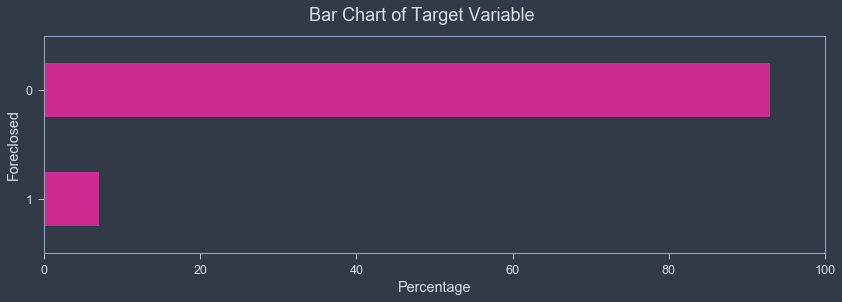

Frequency of Foreclosures
0    355194
1     25651
Name: Foreclosed, dtype: int64

Percentage of Foreclosures
0    93
1     7
Name: Foreclosed, dtype: int32



In [9]:
# Data Cleanings
df = merge_df(df_acq, df_per)
df = missing_treat(df)
df = change_date(df)
df = onehotencoding(df)

print('\nThe number of features is:\n', df.shape[1], sep='')
print('\nThe number of observations is:\n', df.shape[0], sep='')
target_values(df['Foreclosed'], data=True)

#### Target variable has a small numerator (only 7% of foreclosures).  According to King & Zeng (1999) smaller numerators create higher bias in estimation and a higher likelihood of underestimation.  This is because the models have many cases to learn what does not lead to a foreclosure, but few cases to learn of what can lead to a foreclosure.
> King, G., and Zeng, L.  (1999).  Logistic regression in rare events data. Department of Government, Harvard University.  Online: http://GKing.Harvard.Edu.

# Analysis Functions

Splitting data with options to downsample (i.e., create balanced data by removing majority class until it matches the frequency minority class) or upsample (i.e., resample duplicates of minority class until it matches the frequency of the majority class).  Downsampling and upsampling is performed only on the training data in order to maintain the original integrity of the test data.  The data was stratified on the target variable, ensuring that the test data maintains the 7% default rate.

In [10]:
# Modeling training and testing data
def split_data(df, depvar, downsamp=False, upsamp=False):

    # Get the feature vector
    X = df.drop(labels=depvar, axis=1)
    
    # Get the target vector
    y = df[depvar]
    
    # Encoding target variable
    le = LabelEncoder()
    y = le.fit_transform(y)
    
    # Splitting training and testing datasets 30/70
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

    # Define classes for downsampling/upsampling
    ## Indicies of each class' observations
    index0 = np.where(y_train == 0)[0]
    index1 = np.where(y_train == 1)[0]
    
    ## Number of observations in each class
    class0 = len(index0)
    class1 = len(index1)
        
    # Down sample
    if downsamp:  
        
        # For every observation of class 0, randomly sample from class 1 without replacement
        downsampled_index = np.random.choice(index0, size=class1, replace=False)
    
        # Join together class 0's target vector with the downsampled class 1's target vector
        y_train = np.concatenate((y_train[downsampled_index], y_train[index1]))   
        
        X_train = pd.concat([X_train.iloc[downsampled_index], X_train.iloc[index1]], axis=0) 
        
    # Up sample
    if upsamp:  
        
        # For every observation in class 1, randomly sample from class 0 with replacement
        upsampled_index = np.random.choice(index1, size=class0, replace=True)
        
        # Join together class 0's upsampled target vector with class 1's target vector
        y_train = np.concatenate((y_train[index0], y_train[upsampled_index])) 
        
        X_train = pd.concat([X_train.iloc[index0], X_train.iloc[upsampled_index]], axis=0)   

    print('\nNumber of observations for training data:', y_train.shape[0], \
          '\nNumber of observations for testing data:',  y_test.shape[0])
    
    return X_train, X_test, y_train, y_test

Pipeline Function:  

One classifer was attempted, a multilayer perceptron.  The neural network contains three hidden layers with 100 neurons in each.  I tune only the batch size (64 or 128) and the initial learning rate (1e-3, 5e-4, or 1e-4).  Given the computation time involved in computing this on a laptop with only an Intel Core i7-8550U processor, I keep the neural network simple with little tuning.  Complete analysis should attempt a more complex algorithm given the size and difficulties associated with this data.

In [11]:
def pipeline():

    # Creating dictionary of neural network classifer
    clfs = {'mlp': MLPClassifier(random_state=0, learning_rate='adaptive', max_iter=1000, 
                                 hidden_layer_sizes = (100,100,100), alpha=0.01)}
    
    # Initiating dictionary for pipeline
    pipe_clfs = {}
    
    # Pipeline will standardize data and run classifiers
    for name, clf in clfs.items():
        pipe_clfs[name] = Pipeline([('StandardScaler', StandardScaler()), ('clf', clf)])
        
    # Initiate grid
    param_grids = {}
    
    # The parameter grid for multi-layer perceptron
    param_grid = [{'clf__batch_size': [64, 128],
                   'clf__learning_rate_init': [0.0001, 0.00005, 0.00001]}]
    
    param_grids['mlp'] = param_grid
    
    return pipe_clfs, param_grids

Run Model Function:  

The model was tuned based on F1 scores from a three-fold cross validation.

In [12]:
def run_models(pipe_clfs, param_grids):

    # The start time
    start = time.time()
    
    # The list of [best_score_, best_params_, best_estimator_]
    best_score_param_estimators = []
    
    # GridSearchCV
    gs = GridSearchCV(estimator=pipe_clfs['mlp'],
                      param_grid=param_grids['mlp'],
                      scoring='f1',
                      n_jobs=-1,
                      cv=StratifiedKFold(n_splits=3,
                                         shuffle=True,
                                         random_state=0))
    # Fit the pipeline
    gs = gs.fit(X_train, y_train)
    
    # Update best_score_param_estimators
    best_score_param_estimators.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
    # Save best model
    best_model = gs.best_estimator_
        
    # The end time
    end = time.time()
    
    # Print the Run time
    print('Run time: ' + str(end - start))
    
    return best_model

# Imbalanced Prediction

In the first runs, I ran the neural network on the raw data to set baseline results.


Number of observations for training data: 285633 
Number of observations for testing data: 95212


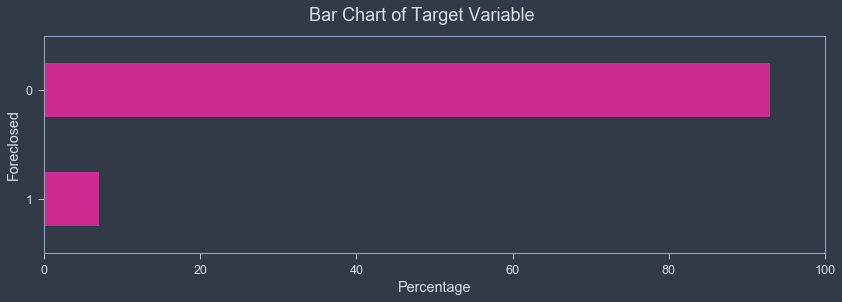

Frequency of Foreclosures
0    266395
1     19238
dtype: int64

Percentage of Foreclosures
0    93
1     7
dtype: int32

Run time: 21517.34213423729


In [13]:
X_train, X_test, y_train, y_test= split_data(df, 'Foreclosed')
target_values(pd.Series(y_train), data=True)
pipe_clfs, param_grids = pipeline()
best_model = run_models(pipe_clfs, param_grids)

In [14]:
# Best multi-layer perceptron
best_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('StandardScaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 MLPClassifier(activation='relu', alpha=0.01, batch_size=64,
                               beta_1=0.9, beta_2=0.999, early_stopping=False,
                               epsilon=1e-08,
                               hidden_layer_sizes=(100, 100, 100),
                               learning_rate='adaptive',
                               learning_rate_init=0.0001, max_iter=1000,
                               momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=0, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)

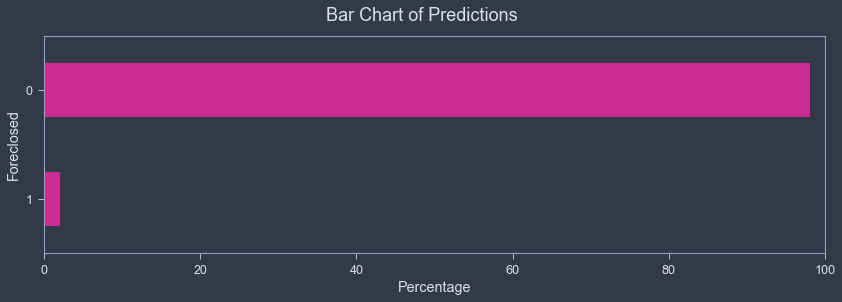

Frequency of Foreclosures
0    92842
1     2370
dtype: int64

Percentage of Foreclosures
0    98
1     2
dtype: int32

Accuracy: 0.92
Precision: 0.3
F1: 0.16

Confusion matrix:
              Predicted False  Predicted True
Actual False            87140            1659
Actual True              5702             711

Final Precision Percentages:
              Predicted False  Predicted True
Actual False             93.9            70.0
Actual True               6.1            30.0

Final Recall Percentages:
              Predicted False  Predicted True
Actual False             98.1             1.9
Actual True              88.9            11.1


In [15]:
# Table of predictions versus actuals
y_pred = best_model.predict(X_test)
target_values(pd.Series(y_pred), prediction=True)

# Overall Scores
print('Accuracy:', end=' ')
print(accuracy_score(y_test, y_pred).round(2))
print('Precision:', end=' ')
print(precision_score(y_test, y_pred).round(2))
print('F1:', end=' ')
print(f1_score(y_test, y_pred).round(2))

# Confusion Matrix
print("\nConfusion matrix:")
PredictTable = pd.crosstab(y_test, y_pred)
PredictTable.columns = ['Predicted False', 'Predicted True']
PredictTable.index = ['Actual False', 'Actual True']
print(PredictTable)
# Precision Table
print('\nFinal Precision Percentages:')
PrecisionTable = ( (PredictTable/(PredictTable.sum(0)))*100 ).round(1)
print(PrecisionTable)
# Recall Table
print('\nFinal Recall Percentages:')
RecallTable = ( (PredictTable.div(PredictTable.sum(axis=1), axis=0))*100 ).round(1)
print(RecallTable)

#### Findings:  
<br>

On the test data, the final F1 score was a pitful 0.16.  As expected, the accuracy was high at 0.92.  This is because the model mostly learned what does not lead to a default as opposed to what led to a default.  It therefore predicted 98% of cases to be a non-default with 93.9% of those being correct.  

The false negative rate is poor:  of the actual defaults, 88.9% were falsely predicted as non-defaults.

# Downsampling Prediction

In the second model runs, I downsampled the data, randomly removing the non-default data to match the frequency of the default data in the training sample.  This caused the training data to fall from 285,633 observations to 38,476.  

Because I artifically balanced the data, I increased the threshold defining a default to a predicted probability of 0.75.  Downsampling causes the model to better find variation that could cause a mortgage default.  However, as the model is trained on data that no longer represents the true balance of mortgage defaults, it overpredicts defaults, requiring a stricter threshold defining a default.


Number of observations for training data: 38476 
Number of observations for testing data: 95212


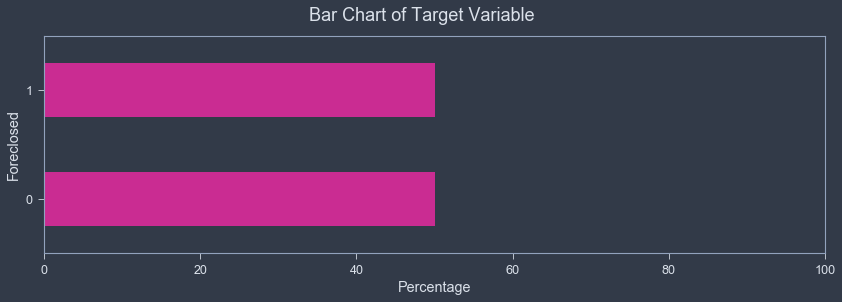

Frequency of Foreclosures
1    19238
0    19238
dtype: int64

Percentage of Foreclosures
1    50
0    50
dtype: int32

Run time: 6659.295145511627


c:\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [16]:
X_train, X_test, y_train, y_test= split_data(df, 'Foreclosed', downsamp=True)
target_values(pd.Series(y_train), data=True)
pipe_clfs, param_grids = pipeline()
best_model = run_models(pipe_clfs, param_grids)

In [17]:
# Best multi-layer perceptron
best_model.fit(X_train, y_train)

c:\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Pipeline(memory=None,
         steps=[('StandardScaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 MLPClassifier(activation='relu', alpha=0.01, batch_size=128,
                               beta_1=0.9, beta_2=0.999, early_stopping=False,
                               epsilon=1e-08,
                               hidden_layer_sizes=(100, 100, 100),
                               learning_rate='adaptive',
                               learning_rate_init=1e-05, max_iter=1000,
                               momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=0, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)

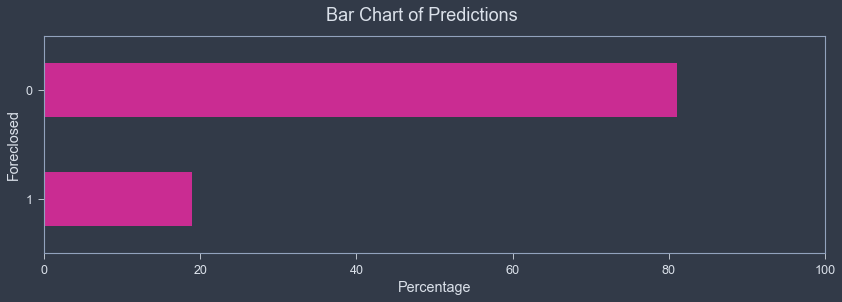

Frequency of Foreclosures
0    77547
1    17665
Name: Default, dtype: int64

Percentage of Foreclosures
0    81
1    19
Name: Default, dtype: int32

Accuracy: 0.82
Precision: 0.19
F1: 0.29

Confusion matrix:
              Predicted False  Predicted True
Actual False            74578           14221
Actual True              2969            3444

Final Precision Percentages:
              Predicted False  Predicted True
Actual False             96.2            80.5
Actual True               3.8            19.5

Final Recall Percentages:
              Predicted False  Predicted True
Actual False             84.0            16.0
Actual True              46.3            53.7


In [18]:
# Table of predictions versus actuals
y_proba = pd.DataFrame(best_model.predict_proba(X_test), columns=["Did not Default", "Default"])
y_pred = y_proba["Default"].map(lambda x: 1 if x >= 0.75 else 0)
target_values(pd.Series(y_pred), prediction=True)

# Overall Scores
print('Accuracy:', end=' ')
print(accuracy_score(y_test, y_pred).round(2))
print('Precision:', end=' ')
print(precision_score(y_test, y_pred).round(2))
print('F1:', end=' ')
print(f1_score(y_test, y_pred).round(2))

# Confusion Matrix
print("\nConfusion matrix:")
PredictTable = pd.crosstab(y_test, y_pred)
PredictTable.columns = ['Predicted False', 'Predicted True']
PredictTable.index = ['Actual False', 'Actual True']
print(PredictTable)
# Precision Table
print('\nFinal Precision Percentages:')
PrecisionTable = ( (PredictTable/(PredictTable.sum(0)))*100 ).round(1)
print(PrecisionTable)
# Recall Table
print('\nFinal Recall Percentages:')
RecallTable = ( (PredictTable.div(PredictTable.sum(axis=1), axis=0))*100 ).round(1)
print(RecallTable)

#### Findings:  
<br>

On the test data, the final test score almost doubled from the baseline's 0.16 to 0.29. When the model predicted a non-default, only 3.8% was it wrong.  The false negative rate improved from the baseline's 88.9% to 46.3%.  

However, the model greatly overpredicted defaults, predicting 19% defaults when the true value was 7%. This caused the model's precision to fall from the baseline's 30% to 19.5%. 

# Upsampling Prediction

In the final model runs, I upsampled the data, randomly removing the non-default data to match the frequency of the default data in the training sample.  This caused the training data to increase from 285,633 observations to 532,790.  

Because I artifically balanced the data, I increased the threshold defining a default to a predicted probability of 0.75.  Similar to downsampling, upsampling causes the model to better find variation that could cause a mortgage default.  However, as the model is trained on data that no longer represents the true balance of mortgage defaults, it overpredicts defaults, requiring a stricter threshold defining a default.


Number of observations for training data: 532790 
Number of observations for testing data: 95212


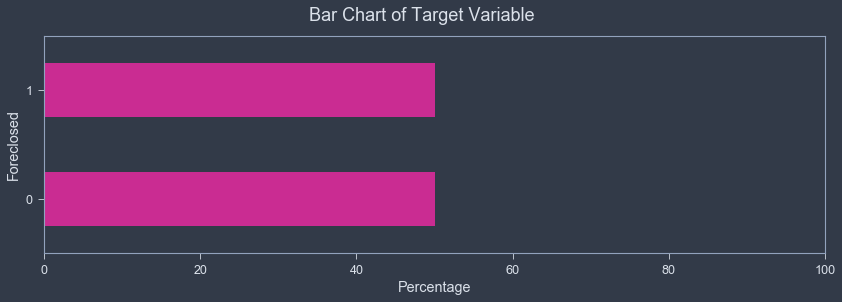

Frequency of Foreclosures
1    266395
0    266395
dtype: int64

Percentage of Foreclosures
1    50
0    50
dtype: int32

Run time: 59529.14437627792


In [19]:
X_train, X_test, y_train, y_test= split_data(df, 'Foreclosed', upsamp=True)
target_values(pd.Series(y_train), data=True)
pipe_clfs, param_grids = pipeline()
best_model = run_models(pipe_clfs, param_grids)

In [20]:
# Best multi-layer perceptron
best_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('StandardScaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 MLPClassifier(activation='relu', alpha=0.01, batch_size=128,
                               beta_1=0.9, beta_2=0.999, early_stopping=False,
                               epsilon=1e-08,
                               hidden_layer_sizes=(100, 100, 100),
                               learning_rate='adaptive',
                               learning_rate_init=0.0001, max_iter=1000,
                               momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=0, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)

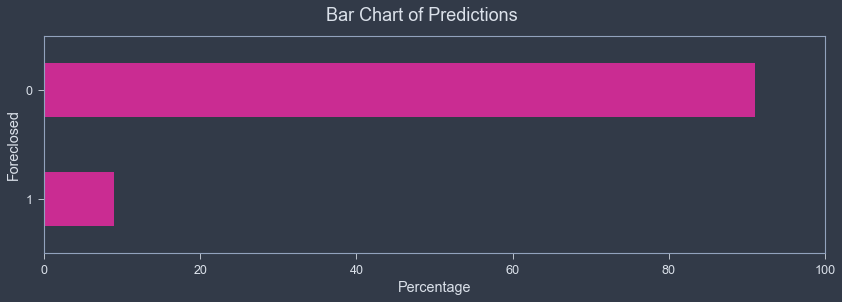

Frequency of Foreclosures
0    87110
1     8102
Name: Default, dtype: int64

Percentage of Foreclosures
0    91
1     9
Name: Default, dtype: int32

Accuracy: 0.88
Precision: 0.21
F1: 0.24

Confusion matrix:
              Predicted False  Predicted True
Actual False            82418            6381
Actual True              4692            1721

Final Precision Percentages:
              Predicted False  Predicted True
Actual False             94.6            78.8
Actual True               5.4            21.2

Final Recall Percentages:
              Predicted False  Predicted True
Actual False             92.8             7.2
Actual True              73.2            26.8


In [21]:
# Table of predictions versus actuals
y_proba = pd.DataFrame(best_model.predict_proba(X_test), columns=["Did not Default", "Default"])
y_pred = y_proba["Default"].map(lambda x: 1 if x >= 0.75 else 0)
target_values(pd.Series(y_pred), prediction=True)

# Overall Scores
print('Accuracy:', end=' ')
print(accuracy_score(y_test, y_pred).round(2))
print('Precision:', end=' ')
print(precision_score(y_test, y_pred).round(2))
print('F1:', end=' ')
print(f1_score(y_test, y_pred).round(2))

# Confusion Matrix
print("\nConfusion matrix:")
PredictTable = pd.crosstab(y_test, y_pred)
PredictTable.columns = ['Predicted False', 'Predicted True']
PredictTable.index = ['Actual False', 'Actual True']
print(PredictTable)
# Precision Table
print('\nFinal Precision Percentages:')
PrecisionTable = ( (PredictTable/(PredictTable.sum(0)))*100 ).round(1)
print(PrecisionTable)
# Recall Table
print('\nFinal Recall Percentages:')
RecallTable = ( (PredictTable.div(PredictTable.sum(axis=1), axis=0))*100 ).round(1)
print(RecallTable)

#### Findings:  
<br>

On the test data, the final test score improved from the baseline's 0.16 to 0.24. The model predicted a reasonable number of defaults, predicting 9% when the true value was 7%.  It produced a higher precision score compared to the downsampling run (21.2% compared to 19.5%).  

However, its false negative rate is higher than the downsampling run at 73.2% (it was 46.3% in the downsampling run and 88.9% in the baseline run).  In other words, this model has the best precision but lower recall then the downsampling run.  

# Conclusion

The downsampling and upsampling runs fared much better than the baseline results.  The downsampling run produced the best harmonized balance between precision and recall, leading to the most confident results.  Perhaps most importantly, it had the lowest false negative rate.  Of defaults in the test data:
- The downsampling run correctly predicted 53.7%
- The upsampling run correctly predicted 26.8%
- The imbalanced run (baseline) correctly predicted 11.1%  

<br>

The upsampling run also performed much better than the baseline results.  Due to the large size of its training dataset (532,790) may have caused the model to underperform due to limitations in the hardware used for analysis.  A more complex neural network run on a more powerful PC or, ideally, on a server with GPU resources may have enabled the upsampling run to outperform the downsampling run.  
<br>

Overall, the runs were not sufficient to produce a meaningful model.  The best run only classified slightly over half of defaults correctly.  This blog post only examined training sampling.  Better computation power could enhance this analysis given the data's complexity (99 features and 380,845 observations).  There were model convergence on some epochs, particularly with the upsampling run, which could be resolved by increasing computation power and increasing the number of iterations.  Besides better computation power, feature selection/feature engineering techniques should be deployed.  In particular, an advanced technique known as feature embedding would likely improve results in very substanive ways.